# 1. Summary

#### Aim:
To explore and understand the spending behaviour of customers, and segments/groups that exist in the data.

#### Data:
- A data set with 96510 samples and 22 features was used for this analysis. 
- There were no missing data. Personally identifiable information (PII) data such as cc number, first name, last name, address, etc. were de-scoped from the data/cluster analysis.


#### Methods:

- Cluster analysis using k-Means and DBSCAN were employed. Particulalry, we used,
    - k-Means with continuous numeric features (amount, avg amount in 60 days) using Quantile transformation and Mahalanobis distance.
    - k-Means with spatio-numeric features normalised and Euclidean distance.
    - DBSCAN with spatio-numeric features normalised and Euclidean distance.
    - DBSCAN with continuous numeric features (amount, avg amount in 60 days) using Quantile transformation and Mahalanobis distance.

#### Results and findings:

- k-Means with continuous numeric features (amount, avg amount in 60 days) suggest three clusters/segments (Elbow plot: 3 Ks, Silhouette score: ~0.33).
    - There are three spending segments - high, moderate, and low.
        - Some of the moderate spenders appear to also spend high on ad-hoc basis.
        - Some of the low spenders have higher mean spend in the last 60 days.

- k-Means with spatio-numeric features suggest either two or four clusters/segments (Elbow plot: 4 Ks, Silhouette score: ~0.70).
    - Two segments appear to be sensible - 
        - High value and high volume.
        - Low value and low volume.

- DBSCAN with spatio-numeric features had fit the data with one cluster (Silhouette score: 0.59). This fit wasn't interpretable.

- DBSCAN with continuous numeric features had fit the data with three clusters (Silhouette score: 0.60). There are three/four clusters in this fit including noise points/outliers.

# 2. Technical notes

### a. Exploratory data analysis

In [1]:
!python --version

# import libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sb

from imblearn.over_sampling import SMOTE

import scipy
import statsmodels.api as sm

import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer, QuantileTransformer, MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, cut_tree, dendrogram

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer

import warnings
warnings.filterwarnings("ignore") # Suppress all warnings


Python 3.11.2


##### Read in the data 

In [2]:
data = pd.read_csv('\\DATA\\fraud_data.csv', index_col=False)

##### Inspect the data

In [3]:
# shape
data.shape

(96510, 22)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96510 entries, 0 to 96509
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   trans_datetime       96510 non-null  object 
 1   cc_num               96510 non-null  int64  
 2   merchant             96510 non-null  object 
 3   category             96510 non-null  object 
 4   amount               96510 non-null  float64
 5   firstname            96510 non-null  object 
 6   lastname             96510 non-null  object 
 7   gender               96510 non-null  object 
 8   street               96510 non-null  object 
 9   city                 96510 non-null  object 
 10  state                96510 non-null  object 
 11  zip                  96510 non-null  int64  
 12  lat                  96510 non-null  float64
 13  lon                  96510 non-null  float64
 14  city_pop             96510 non-null  int64  
 15  job                  96510 non-null 

##### Subset and select numeric features

In [5]:
data = data[['lat', 'lon', 'city_pop', 'amount', 'age', 'num_trans_60d', 'num_trans_24h', 'num_fraud_trans_24h', 'avg_trans_amt_60d', 'is_fraud']]

##### Visualise the geographic locations on a map

In [6]:
# Create a plot with latitude and longitude
fig = px.scatter_geo(data,
                     lat='lat',
                     lon='lon',
                     #text='state',  # Add labels to points
                     title='Geographical locations of transactions',
                     template='plotly')

fig.show()

Comments: 
- Almost all transactions are from the US region.

#### Stratify sample the data

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data[['lat', 'lon', 'city_pop', 'age', 'amount', 'num_trans_60d', 'num_trans_24h', 'num_fraud_trans_24h',
                                                          'avg_trans_amt_60d']],
                                                    data[['is_fraud']], 
                                                    stratify=data[['is_fraud']],
                                                    test_size=0.8, 
                                                    random_state=0)

Comments:

Take 20% for cluster analysis.

#### Try k-Means with continuous numeric features using Quantile transformer and Mahalanobis distance

##### Scale the features

In [8]:
# Scale
scaler = QuantileTransformer(output_distribution='normal')
model = scaler.fit(X_train[['amount', 'avg_trans_amt_60d']])

data_scaled = pd.DataFrame(model.transform(X_train[['amount', 'avg_trans_amt_60d']]))


##### Fit k-Means, collect SSE and Silhoutte score

In [9]:
K = range(2, 9)
fits = []
sse = []
silhoutte = []


for k in K:
    # train the model for current value of k on training data
    model = KMeans(n_clusters = k, random_state = 0, n_init='auto').fit(data_scaled)
    
    # append the model to fits
    fits.append(model)
    
    # Append the SSE
    sse.append(model.inertia_)

    # Append the silhouette score 
    silhoutte.append(silhouette_score(data_scaled, model.labels_, metric='mahalanobis'))

##### Visualise the clusters using Elbow plot

Text(0, 0.5, 'SSE')

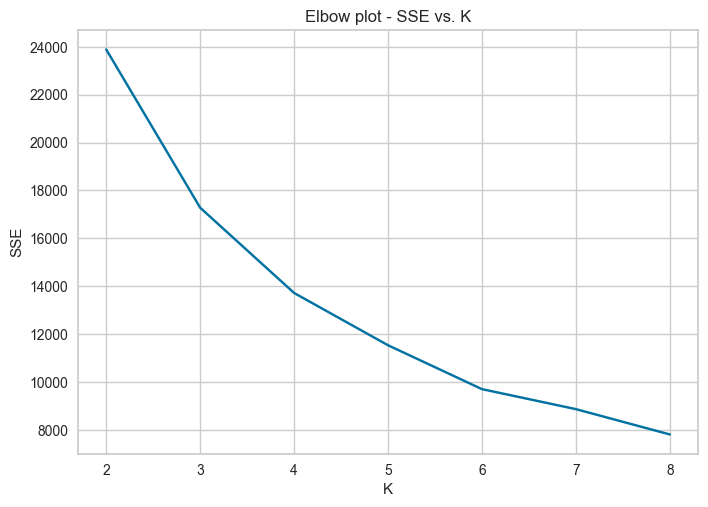

In [10]:
sb.lineplot(x = K, y = sse)
plt.title('Elbow plot - SSE vs. K')
plt.xlabel('K')
plt.ylabel('SSE')

Comments: The first elbow appears to be at three clusters.

##### Visualise silhouette score

Text(0, 0.5, 'Silhouette Score')

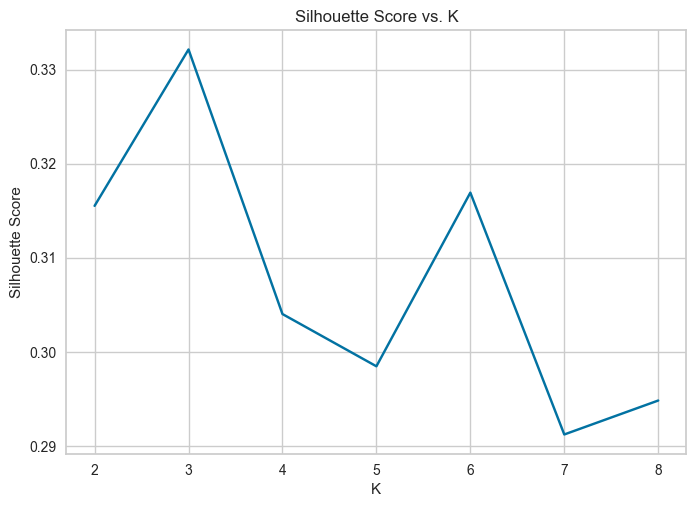

In [11]:
sb.lineplot(x = K, y = silhoutte)
plt.title('Silhouette Score vs. K')
plt.xlabel('K')
plt.ylabel('Silhouette Score')

Comments: It's reassuring to see three clusters appear to have maximum Silhoutte score (~0.335), but not a good fit.

##### Visualise the clusters on feature space

Text(0, 0.5, 'Average Transaction Amount (60 days)')

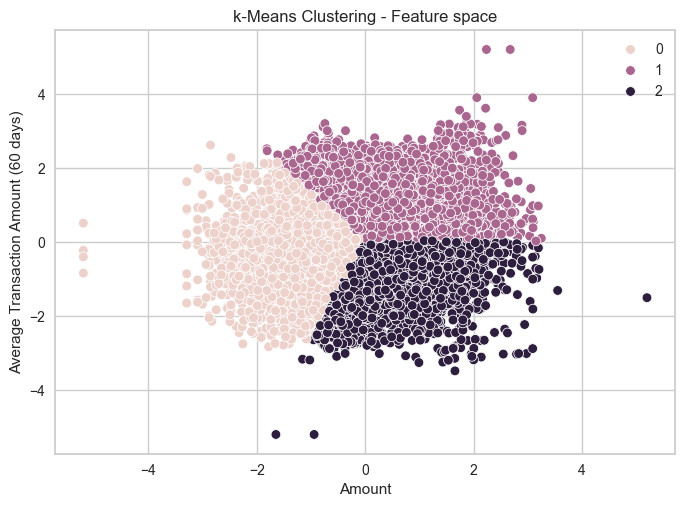

In [12]:
data_scaled.columns = ['amount', 'avg_trans_amt_60d']
sb.scatterplot(data = data_scaled, x = 'amount', y = 'avg_trans_amt_60d', hue = fits[1].labels_)
plt.title('k-Means Clustering - Feature space')
plt.xlabel('Amount')
plt.ylabel('Average Transaction Amount (60 days)')

Comments: 

- There are three spending segments - high, moderate, and low.
    - Some of the moderate spenders appear to also spend high on ad-hoc basis.
    - Some of the low spenders have higher mean spend in the last 60 days.

#### Try k-Means with different scaling method - Normalise

##### Scale the features

In [13]:
# Scale
scaler = Normalizer()
model = scaler.fit(X_train[['lat', 'lon', 'city_pop', 'age', 'amount', 'num_trans_60d', 'num_trans_24h', 'num_fraud_trans_24h', 'avg_trans_amt_60d']])


data_scaled = pd.DataFrame(model.transform(X_train[['lat', 'lon', 'city_pop', 'age', 'amount', 'num_trans_60d', 'num_trans_24h', 'num_fraud_trans_24h', 'avg_trans_amt_60d']]))

##### Fit k-Means, collect SSE and Silhoutte score

In [14]:
K = range(2, 15)
fits = []
sse = []
silhoutte = []


for k in K:
    # train the model for current value of k on training data
    model = KMeans(n_clusters = k, random_state = 0, n_init='auto').fit(data_scaled)
    
    # append the model to fits
    fits.append(model)
    
    # Append the SSE
    sse.append(model.inertia_)

    # Append the silhouette score
    silhoutte.append(silhouette_score(data_scaled, model.labels_, metric='euclidean'))

##### Visualise the clusters using Elbow plot

Text(0, 0.5, 'SSE')

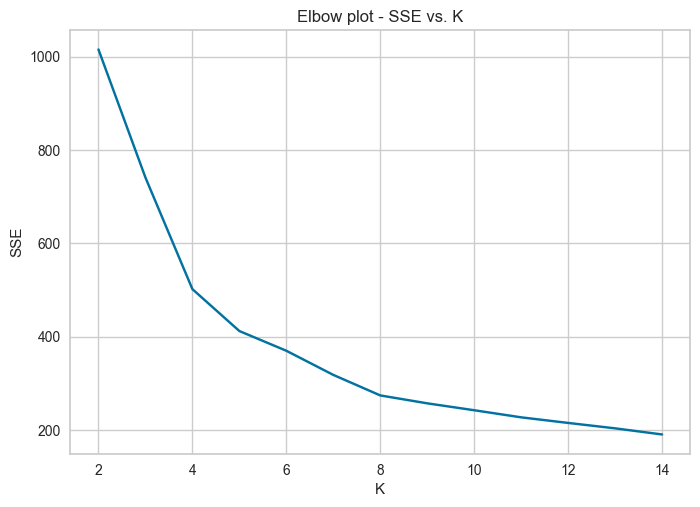

In [15]:
sb.lineplot(x = K, y = sse)
plt.title('Elbow plot - SSE vs. K')
plt.xlabel('K')
plt.ylabel('SSE')

Comments: The elbow is at four clusters.

##### Visualise silhouette score

Text(0, 0.5, 'Silhouette Score')

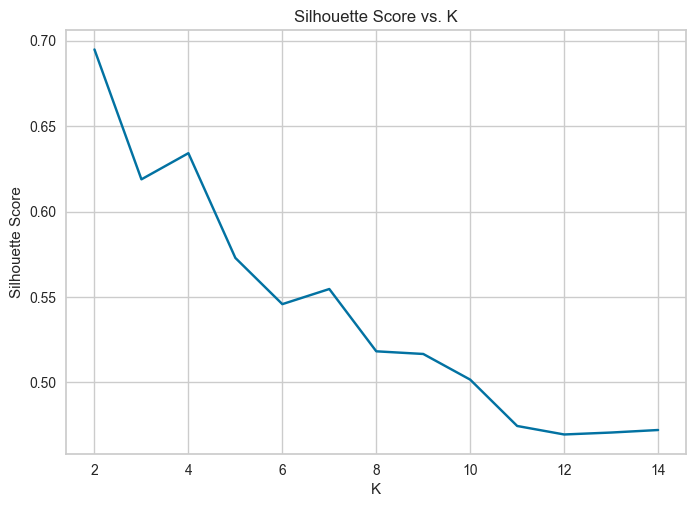

In [16]:
sb.lineplot(x = K, y = silhoutte)
plt.title('Silhouette Score vs. K')
plt.xlabel('K')
plt.ylabel('Silhouette Score')

Comments: The silhouette score suggests two clusters.

##### Visualise the clusters on feature space

Text(0, 0.5, '$ amount')

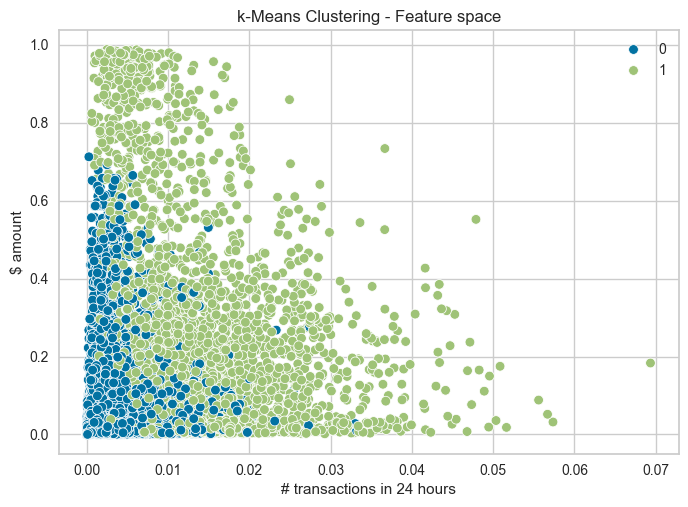

In [17]:
data_scaled.columns = ['lat', 'lon', 'city_pop', 'age', 'amount', 'num_trans_60d', 'num_trans_24h', 'num_fraud_trans_24h', 'avg_trans_amt_60d']

sb.scatterplot(data = data_scaled, x = 'num_trans_24h', y = 'amount', hue = fits[0].labels_)
plt.title('k-Means Clustering - Feature space')
plt.xlabel('# transactions in 24 hours')
plt.ylabel('$ amount')

Text(0, 0.5, 'Average $ trans. in 60 days')

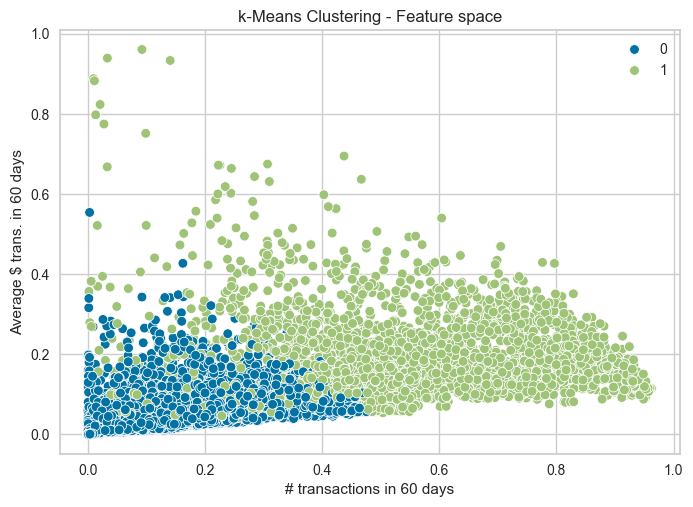

In [18]:

sb.scatterplot(data = data_scaled, x = 'num_trans_60d', y = 'avg_trans_amt_60d', hue = fits[0].labels_)
plt.title('k-Means Clustering - Feature space')
plt.xlabel('# transactions in 60 days')
plt.ylabel('Average $ trans. in 60 days')

Comments:

Two segments appear to be sensible. 
- High value and high volume
- Low value and low volume

#### Try DBSCAN

Split the data and get 10% sample

In [19]:
X_train, X_test, y_train, y_test = train_test_split(data[['lat', 'lon', 'city_pop', 'age', 'amount', 'num_trans_60d', 'num_trans_24h', 'num_fraud_trans_24h',
                                                          'avg_trans_amt_60d']],
                                                    data[['is_fraud']], 
                                                    stratify=data[['is_fraud']],
                                                    test_size=0.9, 
                                                    random_state=0)

Over-sample the fraudulent trans.

In [20]:
smote = SMOTE(sampling_strategy=1, random_state=2701)  # Generate 100% fraud samples
X_smote, y_smote = smote.fit_resample(X_train, y_train)

y_smote.value_counts()

is_fraud
0           8686
1           8686
Name: count, dtype: int64

Scale the features

In [21]:
# Scale
scaler = Normalizer()
model = scaler.fit(X_smote[['lat', 'lon', 'city_pop', 'age', 'amount', 'num_trans_60d', 'num_trans_24h', 'num_fraud_trans_24h', 'avg_trans_amt_60d']])


data_scaled = pd.DataFrame(model.transform(X_smote[['lat', 'lon', 'city_pop', 'age', 'amount', 'num_trans_60d', 'num_trans_24h', 'num_fraud_trans_24h', 'avg_trans_amt_60d']]))

How do we determine the parameters $\epsilon$ and minimum points for DBSCAN?

- Employ Silhouette score and reverse engineer to determine the hyper parameters

In [22]:
# Define ranges for eps and min_samples
eps_range = np.arange(0.01, 1.0, 0.05)
min_samples_range = range(3, 10)
best_score = -1
best_params = None

for eps in eps_range:
    for min_samples in min_samples_range:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(data_scaled)
        
        # Only evaluate if there are at least 2 clusters
        if len(set(labels)) > 1 and -1 in labels:
            score = silhouette_score(data_scaled, labels, metric='euclidean')
            if score > best_score:
                best_score = score
                best_params = {'eps': eps, 'min_samples': min_samples}

print(f"Best Silhouette Score: {best_score}")
print(f"Best Parameters: {best_params}")

Best Silhouette Score: 0.5966888153369043
Best Parameters: {'eps': 0.31000000000000005, 'min_samples': 7}


In [23]:
# Initialize DBSCAN
dbscan = DBSCAN(eps=0.31, min_samples=7)  # Start with known values

# Fit the model
dbscan.fit(data_scaled)



DBSCAN(eps=0.31, min_samples=7)

Visualise the DBSCAN fit

Text(0, 0.5, 'Average $ trans. in 60 days')

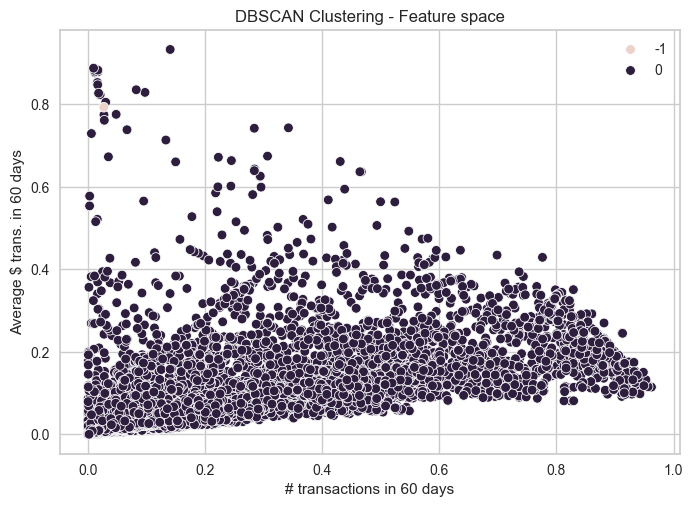

In [24]:
data_scaled.columns = ['lat', 'lon', 'city_pop', 'age', 'amount', 'num_trans_60d', 'num_trans_24h', 'num_fraud_trans_24h', 'avg_trans_amt_60d']

sb.scatterplot(data = data_scaled, x = 'num_trans_60d', y = 'avg_trans_amt_60d', hue = dbscan.labels_)
plt.title('DBSCAN Clustering - Feature space')
plt.xlabel('# transactions in 60 days')
plt.ylabel('Average $ trans. in 60 days')

Comments:
- The DBSCAN algorithm has fit the feature space with just one cluster. We are unable to interpret the cluster fit in this instance.

##### This is for learning purposes only: Try two continuous numeric features, and is_fraud, without SMOTE 

Split the data with two features and stratified sample

In [32]:
X_train, X_test, y_train, y_test  = train_test_split(data[['amount', 'avg_trans_amt_60d']],
                                                    data[['is_fraud']],
                                                    stratify=data[['is_fraud']],
                                                    test_size=0.8, 
                                                    random_state=0)

Scale the features

In [34]:
# Scale
scaler = QuantileTransformer(output_distribution='normal')
model = scaler.fit(X_train[['amount', 'avg_trans_amt_60d']])

data_scaled = pd.DataFrame(model.transform(X_train[['amount', 'avg_trans_amt_60d']]))

Determine the parameters for DBSCAN

In [35]:
# Define ranges for eps and min_samples
eps_range = np.arange(0.01, 1.0, 0.05)
min_samples_range = range(3, 10)
best_score = -1
best_params = None

for eps in eps_range:
    for min_samples in min_samples_range:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(data_scaled)
        
        # Only evaluate if there are at least 3 clusters
        if len(set(labels)) > 3: 
            score = silhouette_score(data_scaled, labels, metric='mahalanobis')
            if score > best_score:
                best_score = score
                best_params = {'eps': eps, 'min_samples': min_samples}

print(f"Best Silhouette Score: {best_score}")
print(f"Best Parameters: {best_params}")

Best Silhouette Score: 0.6025621442188962
Best Parameters: {'eps': 0.51, 'min_samples': 3}


Fit DBSCAN

In [36]:
# Initialize DBSCAN
dbscan = DBSCAN(eps=0.51, min_samples=3)  # Start with known values

# Fit the model
dbscan.fit(data_scaled)

DBSCAN(eps=0.51, min_samples=3)

Get the is_fraud labels

In [38]:
# get the is_fraud labels of the dat
fraud_labels = y_train['is_fraud']
fraud_labels.reset_index(drop=True, inplace=True)

Visualise the clusters

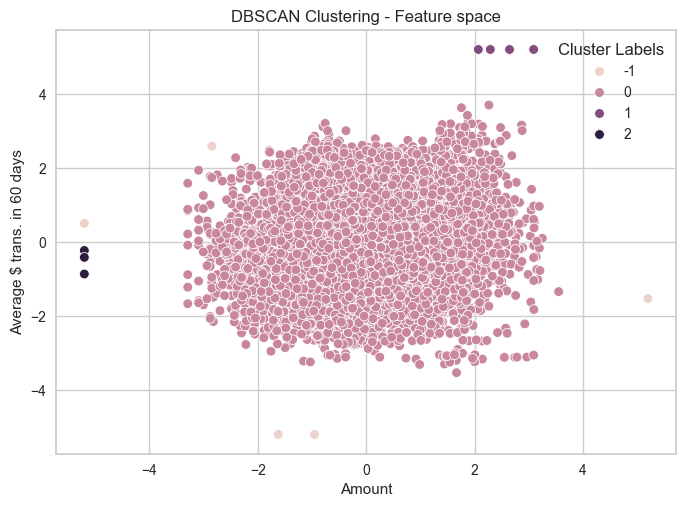

In [40]:
data_scaled.columns = ['amount', 'avg_trans_amt_60d']

sb.scatterplot(data = data_scaled, x = 'amount', 
               y = 'avg_trans_amt_60d', 
               hue = dbscan.labels_)
plt.title('DBSCAN Clustering - Feature space')
plt.xlabel('Amount')
plt.ylabel('Average $ trans. in 60 days')
plt.legend(title = 'Cluster Labels')

Comments: 
- The DBSCAN has fit the feature space well between -3 and +3 z-score. There are three/four clusters including noise points/outliers.

Visualise the DBSCAN fit with is_fraud labels

Text(0, 0.5, 'Average $ trans. in 60 days')

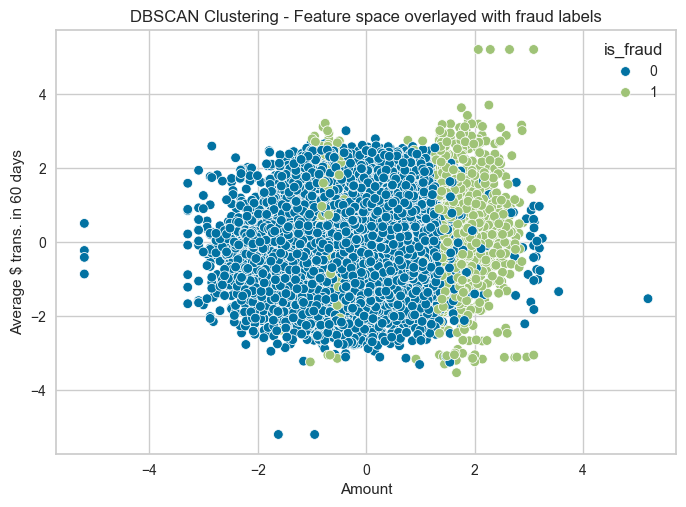

In [42]:
sb.scatterplot(data = data_scaled, x = 'amount', 
               y = 'avg_trans_amt_60d', 
               hue = fraud_labels)
plt.title('DBSCAN Clustering - Feature space overlayed with fraud labels')
plt.xlabel('Amount')
plt.ylabel('Average $ trans. in 60 days')

Comments:
- Most of the fraudulent transactions are above average transaction amount, and very few are below average.